In [1]:
device = 'mps'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import tqdm as tqdm


In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32, 32)),
])

train_dataset = torchvision.datasets.QMNIST('data', train=True, download=True, transform=transforms)
# test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
# print(f"Testing with {len(test_dataset)} samples")


Training with 60000 samples


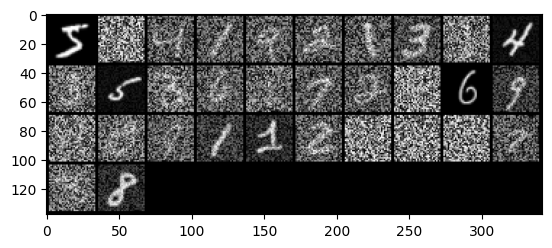

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


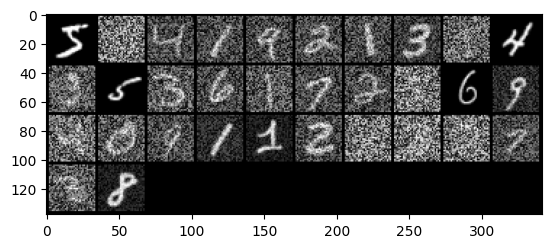

In [19]:
def batch_noiser(img, steps):
    noise = torch.rand_like(img)
    noise_scale = lambda s: 1 - (s / (steps-1))
    noisy_imgs = [
        img * (1 - noise_scale(s)) + noise * noise_scale(s) for s in range(steps)
    ]
    return noisy_imgs

def step_noiser(img, noise, step, total_steps):
    step = step.view(-1, 1, 1, 1)
    noise_scale = lambda s: 1 - (s / (total_steps-1))
    noisy_img = img * (1 - noise_scale(step)) + noise * noise_scale(step)
    return noisy_img

x, y = next(iter(train_loader))
rand_t = torch.randint(0, 10, (x.size(0),))
imgs = step_noiser(x, torch.rand_like(x), rand_t, 10)
grid = torchvision.utils.make_grid(imgs, nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

imgs = step_noiser(x, torch.rand_like(x), rand_t+1, 10)
grid = torchvision.utils.make_grid(imgs, nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.show()


In [5]:
def generate(model, noise, steps, y=None):
    model.eval()
    
    with torch.no_grad():
        for t in range(steps):            
            noise = model(noise, torch.tensor([t] * noise.size(0), device=device))

    return noise


In [6]:
def plot(train_loader, model, steps):
    with torch.no_grad():
        plt.figure(figsize=(20, 3))
        
        x, y = next(iter(train_loader))
        x, y = x.to(device), y.to(device)
        noise = torch.rand_like(x)
        
        generated = generate(model, noise, steps, y)
        plt.figure(figsize=(10, 5))
        grid = torchvision.utils.make_grid(generated, nrow=16).cpu()
        plt.imshow(grid.permute(1, 2, 0))
        plt.title("Generated")
        plt.axis('off')
        plt.show()


In [7]:
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out


class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out
         

# Example usage
model = Unet({
    'im_channels': 1,
    'down_channels': [8, 16, 32, 64],
    'mid_channels': [64, 64, 32],
    'time_emb_dim': 32,
    'down_sample': [True, True, False],
    'num_down_layers': 2,
    'num_mid_layers': 2,
    'num_up_layers': 2,
})

# # Save as ONNX
dummy_input = torch.randn(1, 1, 32, 32)
torch.onnx.export(model, (dummy_input, torch.tensor([0])), "unet.onnx", verbose=False)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

stats = {
    "train_loss": [],
    "test_loss": [],
    "test_accuracy": [],
}

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(
    f"Model uses RAM: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024 / 1024:.2f} MB"
)


/var/folders/dt/jzfvrb8n4rd4cfvmp380lx000000gn/T/ipykernel_16625/3690198092.py:338: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)


Model has 654,345 parameters
Model uses RAM: 2.50 MB


In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Train :: Epoch: 0/10:   0%|          | 1/1875 [00:03<1:05:00,  2.08s/it, loss=0.0248]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

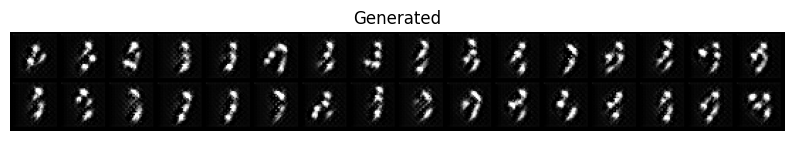

Train :: Epoch: 0/10:  27%|██▋       | 501/1875 [07:38<21:14,  1.08it/s, loss=0.0187] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

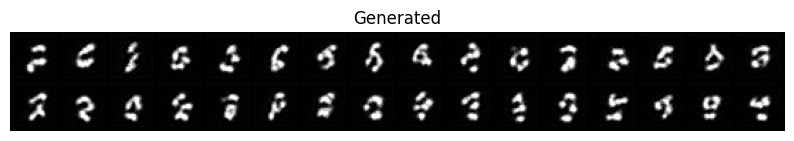

Train :: Epoch: 0/10:  53%|█████▎    | 1001/1875 [35:03<10:38,  1.37it/s, loss=0.0189]   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

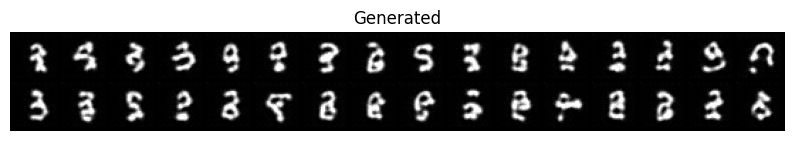

Train :: Epoch: 0/10:  80%|████████  | 1501/1875 [44:28<04:56,  1.26it/s, loss=0.0141]   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

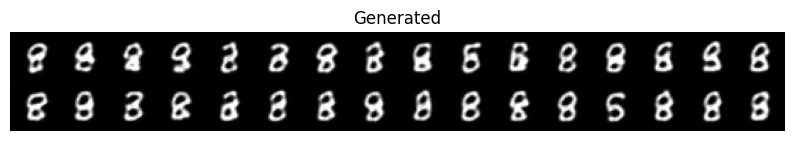

Train :: Epoch: 1/10:   0%|          | 1/1875 [00:07<1:57:02,  3.75s/it, loss=0.0216]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

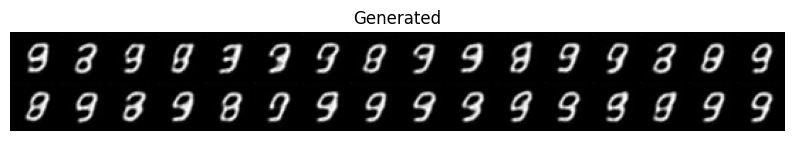

Train :: Epoch: 1/10:   0%|          | 6/1875 [00:18<1:38:37,  3.17s/it, loss=0.0138]


KeyboardInterrupt: 

In [12]:
total_steps = 10

model = model.to(device)
for epoch in range(10):
    model.train()

    with tqdm.tqdm(total=len(train_loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{10}")

        for idx, (x, y) in enumerate(train_loader):
            tq.update(1)
            x, y = x.to(device), y.to(device)

            t = torch.randint(0, total_steps, (x.size(0),), device=device)
            noise = torch.rand_like(x)
            noisy_imgs = step_noiser(x, noise, t, total_steps)
            target = step_noiser(x, noise, t+1, total_steps)
            
            optimizer.zero_grad()
            out = model(noisy_imgs, t)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss.item())
            
            if idx % 500 == 0:
                model.eval()
                plot(train_loader, model, total_steps)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x300 with 0 Axes>

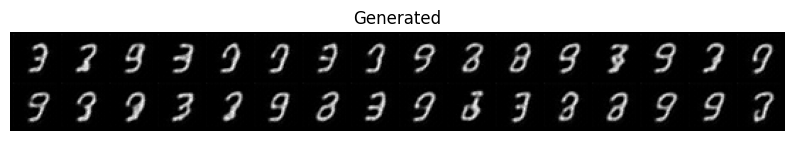

In [14]:
plot(train_loader, model, total_steps)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


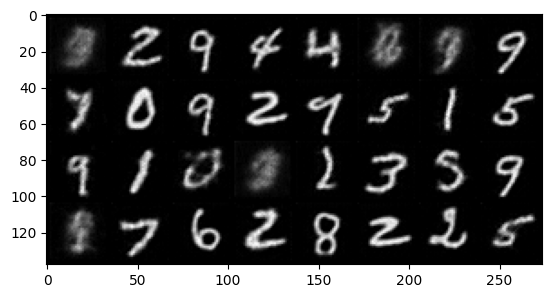

In [17]:
noise = torch.rand_like(x)
t = torch.randint(0, total_steps, (x.size(0),), device=device)
noisy_imgs = step_noiser(x, noise, t, total_steps)
out = model(noisy_imgs, t)
grid = torchvision.utils.make_grid(out, nrow=8).cpu()
plt.imshow(grid.permute(1, 2, 0))
plt.show()
